<a href="https://colab.research.google.com/github/Lampyriss/Lampyriss/blob/main/ShipObjectDetectionPart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ship Object Detection using Faster R-CNN**

Introduction

Model ที่นำมายังไม่เสร็จสมบูณร์เป็นกรณีศึกษาในรายวิชา Fundamental of Artificial Intelligence โดยใช้ Model Faster R-CNN จากเริ่มต้นจนจบโดยใช้ TensorFlow ก่อนอื่นจะทำการแยกคุณลักษณะ (features) จากรูปภาพโดยใช้โมเดล CNN แล้วส่งผ่านเข้าสู่เครือข่าย Region Proposal Network (RPN)

Model Reference from : https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-1

Model Faster R-CNN (Faster Region Convolutional Neural Network) เป็นโมเดลสำหรับการตรวจจับวัตถุในภาพที่มีประสิทธิภาพสูงและมีความแม่นยำ เป็นการปรับปรุงจากโมเดล R-CNN (Region Convolutional Neural Network) และ Fast R-CNN โดยเพิ่มโมดูลที่ชื่อว่า Region Proposal Network (RPN) ที่ช่วยในการสร้างพื้นที่เสนอ (region proposals) อัตโนมัติ และทำให้การตรวจจับวัตถุเป็นไปอย่างรวดเร็ว โดยมีเป้าหมายเพื่อให้สามารถทำงานในเวลาเป็นจริงได้ด้วยความเร็วสูงขึ้นโดยเฉพาะในงานที่ต้องการการตรวจจับวัตถุในเวลาเฉพาะเป้าหมาย (real-time object detection tasks) อย่างกว้างขวางทั้งในงานด้านวิจัยและงานประยุกต์ต่าง ๆ

Model จะประกอบเป็น 5 ส่วนคือ


---


1.สร้าง Model พื้นฐาน Selective Search หรือการใช้ Convolutional Neural Networks (CNN) เพื่อสร้างพื้นที่เสนอ (Region Proposals) ที่เป็นเวคเตอร์ที่เป็นไปได้ที่จะมีวัตถุที่สนใจอยู่


---


2.นำ Model ที่ได้ไปทำการสร้าง Feature Maps ส่งผ่านโครงข่าย CNN เพื่อสร้าง feature maps ที่มีลักษณะการแสดงของภาพที่ปรับเปลี่ยนเชิงลึก (deep feature representation)


---


3.จาก feature maps ที่ได้มา เราสร้าง Regions of Interest (RoIs) โดยใช้ Region Proposals จากขั้นตอนที่ 1 และปรับขนาดให้เข้ากับ feature maps


---


4.สร้างคุณลักษณะ (Features) จาก RoIs: แต่ละ RoI ถูกส่งผ่าน layers เพิ่มเติมของ CNN เพื่อสร้าง feature vectors ที่เกี่ยวข้องกับข้อมูลภายในแต่ละ RoI


---


5.ทำนายหมวดหมู่ของวัตถุและการกรองพื้นที่ที่เกิน: ใช้ layers สุดท้ายของโครงข่าย CNN เพื่อทำนายหมวดหมู่ของวัตถุที่อยู่ในแต่ละ RoI


---



# Step 1 Import and install สิ่งที่จำเป็นต่อการ Train Model

In [ ]:
!pip install opencv-python

OpenCV เป็นตัวย่อของ "Open Source Computer Vision Library" ซึ่งเป็นไลบรารีฟรีและโอเพนซอร์สที่ใช้ในการประมวลผลภาพและวิดีโอ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

show_final_history ใช้สำหรับ plot ค่า loss เเละ ค่า accuracy ของ Dataset


---


plot_confusion_matrix ใช้สำหรับ ตรวจสอบ true positives เพื่อให้เราเห็นภาพรวมของประสิทธิภาพในการตรวจจับวัตถุ

In [ ]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [ ]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

# Step 2 Upload Dataset (Upload Images) เตรียมข้อมูล

In [ ]:
datasets = ['/content/drive/MyDrive/AI/Dataset']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [ ]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

# Step 3  Exploratory Data Analysis (EDA) ขั้นตอนในการสำรวจข้อมูลเพื่อเข้าใจลักษณะและคุณสมบัติของข้อมูล

 เป็นขั้นตอนที่สำคัญในการเข้าใจและตรวจสอบข้อมูลก่อนการดำเนินการต่อไป เพื่อให้เราได้ข้อสรุปเบื้องต้นเกี่ยวกับคุณลักษณะของข้อมูล
 การสร้าง bar plot และ pie plot เป็นเครื่องมือที่มักถูกใช้ในการทำ EDA โดยมีวัตถุประสงค์หลักเพื่อแสดงการกระจายของข้อมูลในชุดข้อมูล โดยเฉพาะการแสดงจำนวนข้อมูลต่อคลาสในกรณีของ bar plot และการแสดงเปอร์เซ็นต์ของการกระจายข้อมูลต่อคลาสในกรณีของ pie plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(images, labels) = load_data() # โหลดข้อมูลเข้าจากฟังชั่น load_data()
images.shape, labels.shape  #จำนวนแถวและคอลัมน์ของ  ข้อมูลimages และข้อมูลlabels

100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


((4000, 48, 48, 3), (4000,))

In [ ]:
n_labels = labels.shape[0] # นับจำนวนแถวในตัวแปร labels

n_, count = np.unique(labels, return_counts=True)   #หาจำนวนของแต่ละคลาสที่มีใน labels เพื่อหาค่าที่ไม่ซ้ำกันใน labels และเก็บผลลัพธ์ไว้ในตัวแปร n_ และ count

df = pd.DataFrame(data = count) # สร้าง DataFrame โดยเก็บข้อมูลจำนวนของแต่ละคลาสที่ได้จากขั้นตอนก่อนหน้าไว้ในคอลัมน์ 'Count'
df['Class Label'] = class_names # เพิ่มคอลัมน์ 'Class Label' ที่มีค่าเป็น class_names
df.columns = ['Count','Class-Label'] #กำหนดชื่อคอลัมน์ใหม่เป็น ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)# กำหนด 'Class-Label' เป็น index ของ DataFrame
df

,Count
Class-Label,
no-ship,3000
ship,1000


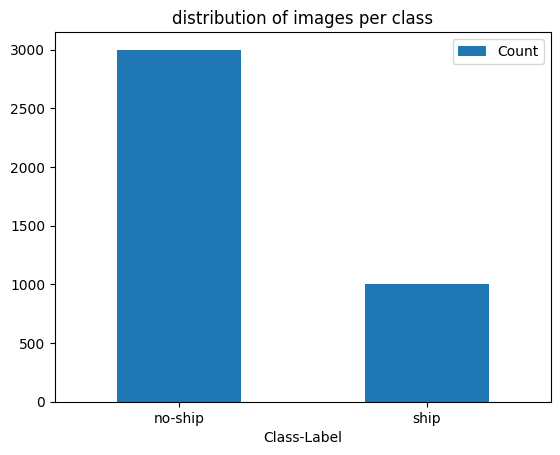

In [ ]:
df.plot.bar(rot=0) #ทำการพล็อตกราฟแท่ง (bar plot) ของข้อมูลจำนวนของแต่ละคลาสใน DataFrame
plt.title("distribution of images per class"); #กำหนดชื่อกราฟเป็น "distribution of images per class"

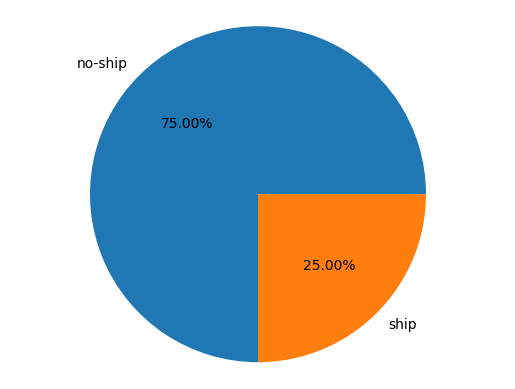

In [ ]:
#พล็อตกราฟแผนภูมิวงกลมของข้อมูลจำนวนของแต่ละคลาส
plt.pie(count,
       explode=(0,0),
       labels=class_names, #กำหนดให้ class_names เป็น labels
       autopct="%1.2f%%") #กำหนดรูปแบบของข้อความในแผนภูมิ เพื่อแสดงเป็นเปอร์เซ็นต์
plt.axis('equal');    #เพื่อให้กราฟแผนภูมิวงกลมมีสัดส่วนที่ถูกต้อง (หรือเท่ากัน) และไม่เบียดเบียน

# Step 4 Augmenting Images of Minority Class

Minority Class เป็นขั้นตอนที่ใช้ในการเพิ่มจำนวนข้อมูลในคลาสที่มีจำนวนน้อยกว่าในชุดข้อมูล เพื่อให้มีการแจกแจงของคลาสที่สมดุลกันในชุดข้อมูล

In [ ]:
AUGMENTATION = True

In [ ]:
# สร้าง  ฟังก์ชัน augment_add() ที่รับพารามิเตอร์ images, seq (โมเดล augmentation), และ labels
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[] #สร้าง list ว่างสำหรับเก็บรูปภาพที่เพิ่มขึ้น
    for idx,img in tqdm(enumerate(images)):   #ลูป for เพื่อวนซ้ำผ่านทุกๆ รูปภาพใน images

        if labels[idx] == 1: # ตรวจสอบว่า labels ของรูปภาพนั้นเป็น 1 หรือไม่
            image_aug_1 = seq.augment_image(image=img)#ทำการ augmentation ภาพรอบที่ 1  โดยใช้โมเดล augmentation (seq)
            image_aug_2 = seq.augment_image(image=img)#ทำการ augmentation ภาพรอบที่ 2  โดยใช้โมเดล augmentation (seq)
            augmented_images.append(image_aug_1)# เพิ่มรูปภาพที่ augment แล้วเข้าไปใน augmented_images รอบที่ 1
            augmented_images.append(image_aug_2)# เพิ่มรูปภาพที่ augment แล้วเข้าไปใน augmented_images รอบที่ 2
            augmented_labels.append(labels[idx])#เพิ่ม label เดิมใน augmented_labels ครั้งที่ 1
            augmented_labels.append(labels[idx])#เพิ่ม label เดิมใน augmented_labels ครั้งที่ 2
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32) #แปลง จาก list เป็น numpy array  numpy array ที่มี dtype เป็น np.float32
    augmented_labels = np.array(augmented_labels, dtype=np.float32) #แปลง จาก list เป็น numpy array  numpy array ที่มี dtype เป็น np.float32

    return (augmented_images, augmented_labels) # คืนค่า augmented_images และ augmented_labels

    pass

In [ ]:
# สร้างโมเดล augmentation โดยใช้ Sequential()
seq = iaa.Sequential( [
    iaa.Fliplr(0.5),             #สลับภาพซ้าย-ขวาโดยมีโอกาส 50%
    iaa.Crop(percent=(0,0.1)),#ครอบภาพโดยตัดขอบข้างของภาพในอัตราส่วน 0-10%
    iaa.LinearContrast((0.75,1.5)),#เพิ่มความคมชัดของภาพโดยเปลี่ยนค่าความเข้มของภาพแบบเชิงเส้น
    iaa.Multiply((0.8,1.2), per_channel=0.2),#เพิ่มความเข้มของสีแต่ละช่องสีของภาพ (RGB) แบบสุ่ม
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},#ปรับเปลี่ยนขนาดของภาพ
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},#ปรับเปลี่ยนตำแหน่งของภาพ
        rotate=(-25,25), #ปรับเปลี่ยนการหมุนของภาพ
        shear=(-8,8)#  ปรับเปลี่ยนการเอียงของภาพ
    )
], random_order=True) # ทำให้การ augmentation ถูกสุ่มลำดับ ซึ่งจะช่วยเพิ่มความหลากหลายให้กับข้อมูลที่ถูก augment อีกด้วย

In [ ]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)# เรียกใช้ฟังก์ชัน augment_add และนำค่าจากฟังก์ชัน ให้กับตัวแปร aug_images และ aug_labels ตามลำดับ
    images = np.concatenate([images, aug_images])#เพื่อเพิ่มข้อมูลการ augmentation เข้าไปใน images เพื่อใช้ในการฝึกโมเดล
    labels = np.concatenate([labels, aug_labels])#เพื่อเพิ่มข้อมูลการ augmentation เข้าไปใน labels เพื่อใช้ในการฝึกโมเดล

4000it [00:02, 1397.18it/s] 


In [ ]:
images.shape, labels.shape #จำนวนแถวและคอลัมน์ของ  ข้อมูลimages และข้อมูลlabels

((6000, 48, 48, 3), (6000,))

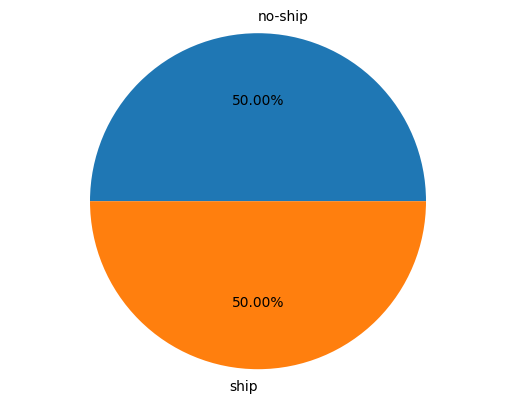

In [ ]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True) #หาจำนวนของแต่ละคลาสที่มีใน labels เพื่อหาค่าที่ไม่ซ้ำกันใน labels และเก็บผลลัพธ์ไว้ในตัวแปร _ และ count
 #พล็อตกราฟแผนภูมิวงกลมของข้อมูลจำนวนของแต่ละคลาส
    plt.pie(count,
           explode=(0,0),
           labels=class_names,#กำหนดให้ class_names เป็น labels
           autopct="%1.2f%%")#กำหนดรูปแบบของข้อความในแผนภูมิ เพื่อแสดงเป็นเปอร์เซ็นต์

    plt.axis('equal');  #เพื่อให้กราฟแผนภูมิวงกลมมีสัดส่วนที่ถูกต้อง (หรือเท่ากัน) และไม่เบียดเบียน

In [ ]:
labels = to_categorical(labels)# แปลงข้อมูล (labels) จากรูปแบบของตัวเลขเป็นรูปแบบ One-Hot Encoding
# การทำ One Hot Encoding บนตัวแปร labels numpy array เป็นกระบวนการที่ใช้ในการแปลงข้อมูลที่มีลักษณะแบบหมวดหมู่

# Step 5 Training Validation and Testing

In [ ]:
np.random.seed(42) #กำหนดค่า seed ให้กับเจเนอเรเตอร์ของตัวสร้างเลขสุ่มของ NumPy
np.random.shuffle(images) # เพื่อสับเรียงข้อมูลในตัวแปร images และ labels

np.random.seed(42)
np.random.shuffle(labels)
# เพื่อเปรียบเทียบผลลัพธ์

In [ ]:
total_count = len(images) #กำหนดค่าของตัวแปร total_count ให้เท่ากับจำนวนข้อมูลทั้งหมดใน images โดยใช้ฟังก์ชัน len() เพื่อนับจำนวนสมาชิกใน images.
total_count

train = int(0.7*total_count) #คำนวณขนาดของชุดฝึก (train), ชุดตรวจสอบ (val), และชุดทดสอบ (test) โดยใช้สัดส่วนที่กำหนดไว้ (70%, 20%, 10%).
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train] #เเบ่งข้อมูลเป็นชุดต่างๆ โดยใช้การ slice ข้อมูลจาก images และ labels
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

In [ ]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0) # นับจำนวนข้อมูลที่มีในแต่ละคลาสของชุดข้อมูลฝึก (train_labels.sum(axis=0)).

    classTotals = train_labels.sum(axis=0) # การคำนวณค่าน้ำหนัก (class weights) สำหรับแต่ละคลาสในชุดข้อมูลฝึก (train_labels) เพื่อใช้ในการปรับความสำคัญของแต่ละคลาสในกระบวนการฝึกโมเดล
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i] # คำนวณค่าน้ำหนักของแต่ละคลาสโดยหารจำนวนมากสุดของข้อมูลในคลาสด้วยจำนวนข้อมูลในแต่ละคลาส classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [ ]:
# ฟังก์ชัน conv_block ด้านบนใช้สำหรับสร้างบล็อกการคอนโวลูชัน (convolutional block) ในโมเดล CNN
def conv_block(X,k,filters,stage,block,s=2): # stage: หมายเลขขั้นของบล็อก (stage) # block: หมายเลขของบล็อก (block) # s: ค่า stride ในการทำคอนโวลูชัน (default เป็น 2)
    # k: ขนาดของ kernel ในการทำคอนโวลูชัน
    conv_base_name = 'conv_' + str(stage)+block+'_branch' #ปรับปรุงค่าในชั้นปรับค่าแบตช์ (BatchNormalization) ด้วย ReLU
    bn_base_name = 'bn_'+str(stage)+block+"_branch" # การเปิดเผย (Activation) ด้วย ReLU

    F1 = filters # filters: จำนวนฟิลเตอร์ (filters) ที่จะใช้ในการคอนโวลูชัน
    # X: ข้อมูลนำเข้า (input data) หรือภาพที่ผ่านการแปลงแล้วจากบล็อกก่อนหน้า
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass
    # ส่วนที่สำคัญของฟังก์ชันนี้คือการสร้างชั้นของคอนโวลูชัน (Conv2D), การปรับปรุงค่าในชั้นปรับค่าแบตช์ (BatchNormalization), และการเปิดเผย (Activation) ด้วย ReLU

การสร้างชั้นของคอนโวลูชัน (Conv2D), การปรับปรุงค่าในชั้นปรับค่าแบตช์ (BatchNormalization), และการเปิดเผย (Activation) ด้วย ReLU เป็นส่วนสำคัญในการสร้างโมเดล Convolutional Neural Network (CNN) ซึ่งเป็นโมเดลที่ได้รับความนิยมสูงสุดในการประมวลผลภาพและข้อมูลที่เป็นตำแหน่ง (spatial data)

In [ ]:
# ฟังก์ชัน basic_model ที่ใช้สร้างโมเดล neural network สำหรับงานประมวลผลภาพ
def basic_model(input_shape,classes):
    # รับขนาดของข้อมูลนำเข้า (input_shape) และจำนวนคลาส (classes) ที่จะแยกแยะ
    X_input = Input(input_shape)
    # สร้างชั้นนำเข้า (Input layer) โดยใช้ค่า input_shape ที่รับเข้ามา
    X = ZeroPadding2D((5,5))(X_input)
    # ใส่ Zero Padding เพื่อเพิ่มพื้นที่ให้กับข้อมูล
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X) # เพิ่มชั้นคอนโวลูชัน (Convolutional Layer) และชั้นปรับปรุงค่าในชั้นปรับค่าแบตช์ (Batch Normalization)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X) # สร้างชั้นโดยใช้ฟังก์ชัน conv_block ที่กำหนดไว้ โดยมีการใช้ Dropout เพื่อลด Overfitting

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X) # สร้างชั้น Flatten เพื่อแปลงข้อมูลให้อยู่ในรูปแบบแถวเดียวกัน
    X = Dense(64)(X) # เพิ่มชั้น Dense และ Dropout ในการป้องกันการเกิด Overfitting
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X) # สร้างชั้น Dense สุดท้ายที่มีจำนวนเท่ากับจำนวนคลาสและใช้ Activation Function เป็น softmax เพื่อให้ได้ผลลัพธ์ในรูปแบบความน่าจะเป็นสำหรับแต่ละคลาส

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC') # สร้างและคืนค่าโมเดล neural network ที่ได้ที่มีชื่อว่า 'Feature_Extraction_and_FC'

    return model
    pass

In [ ]:
model = basic_model(input_shape=(48,48,3),classes=2) # เรียกใช้ฟังก์ชัน basic_model สร้างโมเดล
# input_shape=(48,48,3): รูปร่างของข้อมูลนำเข้า ซึ่งเป็นภาพขนาด 48x48 พิกเซลและมี 3 ช่องสี (RGB)
# classes=2: จำนวนคลาสที่จะแยกแยะ ซึ่งในที่นี้เป็นแบบ binary classification ซึ่งมีคลาสทั้งหมด 2 คลาส

In [ ]:
plot_model(model,to_file='basic_model.png') # ใช้สร้างภาพของโมเดลที่ถูกสร้างขึ้น และบันทึกภาพเอาไว้ในไฟล์ 'basic_model.png
SVG(model_to_dot(model).create(prog='dot',format='svg')) # ใช้สร้างกราฟของโมเดลในรูปแบบของ DOT (Graphviz DOT language)

model.summary()
# เรียกใช้ฟังก์ชัน plot_model และ model_to_dot เพื่อสร้างภาพและ SVG ของโมเดลและแสดงผลสรุปของโมเดลที่สร้างด้วย model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

Graphviz DOT language เป็นภาษาที่ใช้ในการอธิบายโครงสร้างของกราฟในรูปแบบของข้อความ (text-based format) ซึ่งสามารถนำมาใช้ในการสร้างและแสดงผลกราฟต่าง ๆ ได้อย่างมีประสิทธิภาพ

In [ ]:
opt = Adam(lr=1e-3) # lr=1e-3 คือการกำหนดอัตราการเรียนรู้ (learning rate) ให้เท่ากับ 0.001
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy']) # ฟังก์ชัน compile() ซึ่งทำการกำหนดการเรียนรู้ของโมเดล
# จะทำให้โมเดลได้รับการเตรียมพร้อมสำหรับการฝึกและการทดสอบ โดยกำหนดการเรียนรู้, ฟังก์ชันสูญเสียและวัตถุประสงค์ในการวัดประสิทธิภาพ

optimizer: กำหนดอัลกอริทึมในการปรับค่าพารามิเตอร์ของโมเดลในระหว่างกระบวนการฝึก (training)  optimizer เป็น Adam ซึ่งเป็นวิธีการปรับค่าพารามิเตอร์ที่มีประสิทธิภาพมากในการฝึกโมเดล

loss: กำหนดฟังก์ชันสูญเสีย (loss function) ที่ใช้ในการปรับค่าพารามิเตอร์ของโมเดลในระหว่างการฝึก

metrics: กำหนดวัตถุประสงค์ในการวัดประสิทธิภาพของโมเดล ซึ่งในที่นี้ใช้ 'accuracy' เพื่อให้สามารถติดตามความถูกต้องของการทำนายในขณะทดสอบ (testing) โมเดลได้

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
# บันทึกโมเดลที่มีประสิทธิภาพที่สุดของเวอร์ชันก่อนหน้า (best model) ตามค่าที่กำหนด (ในที่นี้คือ val_accuracy) ลงในไฟล์ "model_weights.h5"
logs = TensorBoard("logs") # ใช้สร้าง TensorBoard callback ซึ่งเป็นตัวช่วยในการเก็บข้อมูลการฝึกของโมเดล โดยกำหนดให้ข้อมูลนี้ถูกบันทึกไว้ในไดเรกทอรีที่ชื่อว่า "logs"

TensorBoard callback ทำหน้าที่เก็บข้อมูลการฝึกของโมเดลทุก ๆ เพิ่มเข้าไปในไดเรกทอรีที่กำหนดไว้ ซึ่งข้อมูลเหล่านี้รวมถึงข้อมูลการฝึก

เป็นการกำหนด checkpoint และ TensorBoard callback สำหรับใช้ในการฝึกโมเดล neural network

In [ ]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,  # กำหนดจำนวนขั้นตอนที่ต้องทำในแต่ละรอบการฝึก
                   epochs=epochs, # กำหนดจำนวนรอบการฝึกโมเดล
                   verbose=1, # ระบุให้แสดงผลลัพธ์ของการฝึกโมเดลทุกๆ รอบ
                   validation_data=(val_images,val_labels), # กำหนดข้อมูลการทดสอบเพื่อให้ความแม่นยำของโมเดลในแต่ละรอบการฝึก
                   validation_steps=len(val_images)//batch_size, #  กำหนดจำนวนขั้นตอนที่ต้องทำในแต่ละรอบการทดสอบ
                   callbacks=[checkpoint, logs] # ระบุ callbacks ที่ใช้ในการบันทึกโมเดลที่ดีที่สุด (checkpoint) และเก็บข้อมูลการฝึกของโมเดลสำหรับ TensorBoard (logs)
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )
# เริ่มต้นการฝึกโมเดล neural network โดยใช้ข้อมูลการฝึก (train_images และ train_labels) และข้อมูลการทดสอบ (val_images และ val_labels)

Epoch 1/50
261/262 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8095
Epoch 1: val_accuracy improved from -inf to 0.91583, saving model to model_weights.h5
262/262 [==============================] - 10s 29ms/step - loss: 0.4022 - accuracy: 0.8103 - val_loss: 0.2664 - val_accuracy: 0.9158
Epoch 2/50
  4/262 [..............................] - ETA: 6s - loss: 0.2586 - accuracy: 0.8971

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/262 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9202
Epoch 2: val_accuracy did not improve from 0.91583
262/262 [==============================] - 8s 30ms/step - loss: 0.2103 - accuracy: 0.9198 - val_loss: 0.3405 - val_accuracy: 0.8500
Epoch 3/50
262/262 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9446
Epoch 3: val_accuracy improved from 0.91583 to 0.93500, saving model to model_weights.h5
262/262 [==============================] - 7s 27ms/step - loss: 0.1448 - accuracy: 0.9446 - val_loss: 0.1692 - val_accuracy: 0.9350
Epoch 4/50
260/262 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9519
Epoch 4: val_accuracy improved from 0.93500 to 0.96250, saving model to model_weights.h5
262/262 [==============================] - 8s 30ms/step - loss: 0.1185 - accuracy: 0.9520 - val_loss: 0.1028 - val_accuracy: 0.9625
Epoch 5/50
262/262 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9658
Ep


Epoch 48: val_accuracy did not improve from 0.99083
262/262 [==============================] - 4s 14ms/step - loss: 0.0338 - accuracy: 0.9855 - val_loss: 0.0751 - val_accuracy: 0.9775


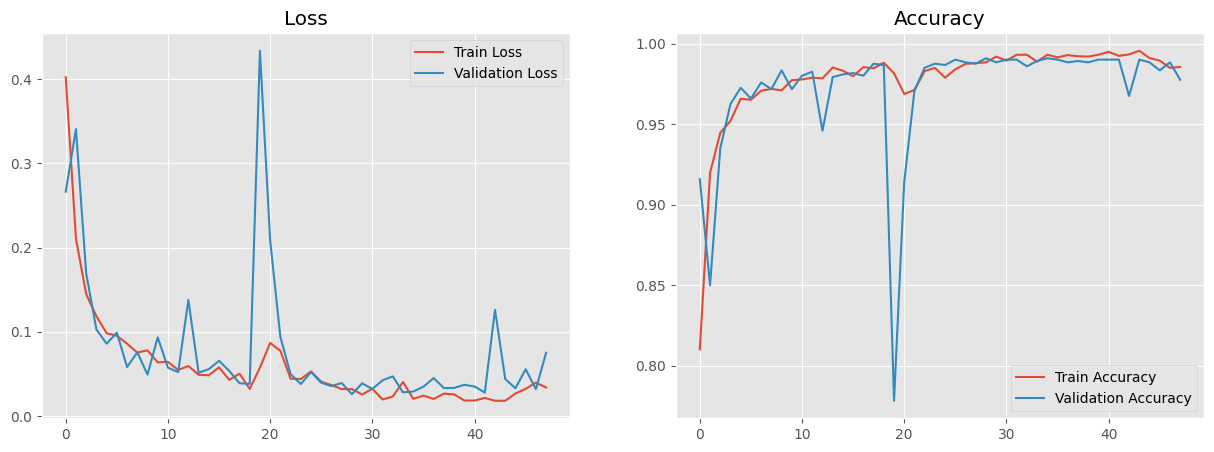

In [ ]:
show_final_history(history) # สร้างกราฟแสดงค่าความแม่นยำของการฝึกและการทดสอบของโมเดล โดยใช้ข้อมูลที่เก็บไว้ในตัวแปร history

In [ ]:
val_pred = model.predict(val_images) # เพื่อทำการทำนายผลลัพธ์ของชุดข้อมูลการทดสอบ val_images จากโมเดลที่ฝึก โดยผลลัพธ์ที่ได้จะเป็นค่าความน่าจะเป็น (probability)
val_pred = np.argmax(val_pred,axis=1) # เพื่อให้ได้เฉพาะค่าดัชนีที่มีความน่าจะเป็นสูงสุดของแต่ละภาพ
val_pred.shape #  (จำนวนภาพที่ใช้ในการทดสอบ,) ซึ่งแสดงถึงจำนวนของการทำนายสำหรับแต่ละภาพที่ใช้ในการทดสอบ

38/38 [==============================] - 1s 12ms/step


(1200,)

<Figure size 640x480 with 0 Axes>

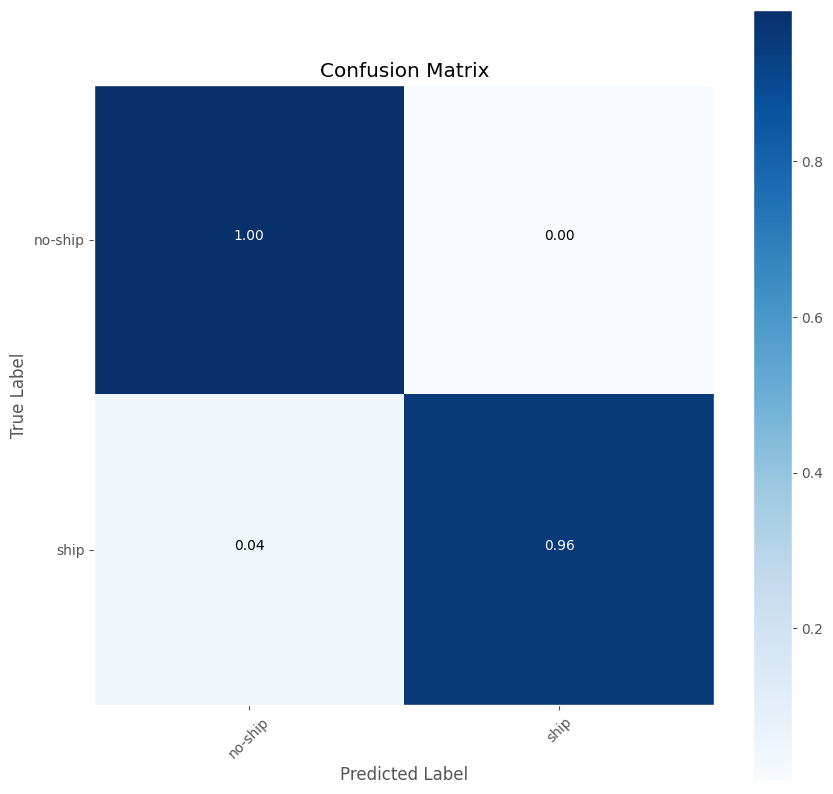

In [ ]:
val_actual = np.argmax(val_labels,axis=1) # หาค่าดัชนีที่มีค่าสูงสุดในแต่ละแถวของ val_labels เพื่อให้ได้ค่าคลาสที่ถูกต้องที่สุดสำหรับแต่ละภาพในชุดข้อมูลการทดสอบ val_images.

cnf_mat = confusion_matrix(val_actual, val_pred) # สร้างเมทริกซ์การสับเรียงโดยใช้ค่าคลาสจริง (val_actual) และค่าคลาสที่ทำนายได้ (val_pred) จากโมเดล โดยใช้ฟังก์ชัน confusion_matrix
np.set_printoptions(precision=2) #  กำหนดค่า precision ของเลขทศนิยมในเมทริกซ์การสับเรียงเป็น 2 หลักทศนิยม

plt.figure() # สร้างภาพใหม่สำหรับแสดงผล
plot_confusion_matrix(cnf_mat,classes=class_names) # เรียกใช้ฟังก์ชัน plot_confusion_matrix เพื่อแสดงผลของเมทริกซ์การสับเรียง โดยส่งค่าเมทริกซ์ cnf_mat และชื่อคลาส class_names เข้าไป
plt.grid(None) # ไม่แสดงเส้นกริดในกราฟ
plt.show(); # แสดงกราฟ confusion matrix บนหน้าต่างแสดงผลลัพธ์

In [ ]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape
# หาค่าที่มีความน่าจะเป็นสูงสุดในแต่ละแถวของเมทริกซ์ โดยที่แต่ละแถวนั้นแทนด้วยการทำนายของโมเดลสำหรับแต่ละภาพในชุดข้อมูลทดสอบ

19/19 [==============================] - 0s 12ms/step


(600,)

<Figure size 640x480 with 0 Axes>

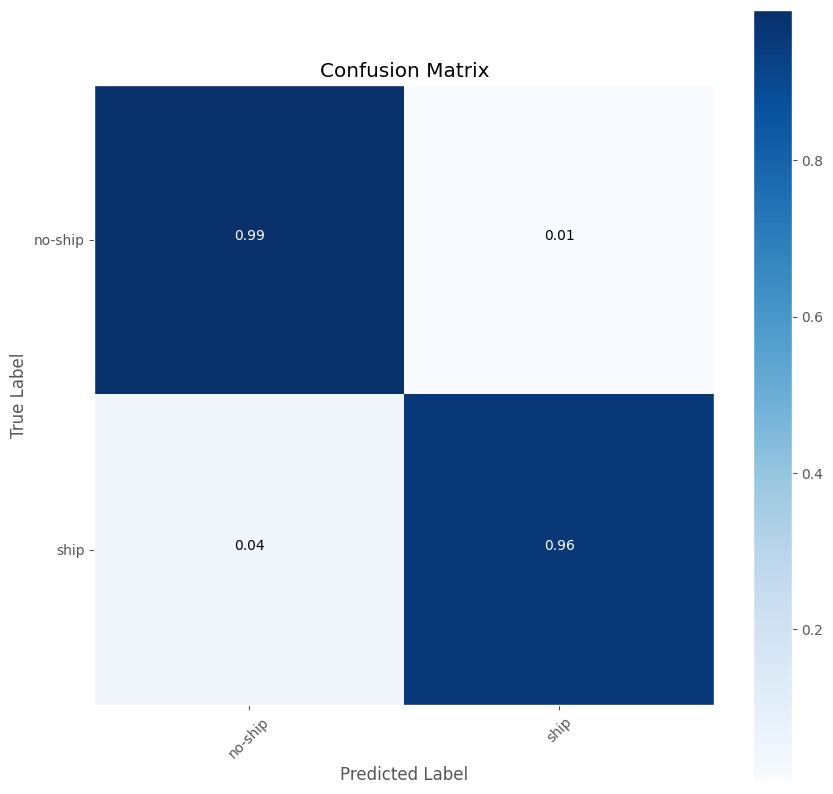

In [ ]:
test_actual = np.argmax(test_labels,axis=1) # เพื่อหาค่าคลาสที่เป็นไปได้ที่สูงสุด

cnf_mat_test = confusion_matrix(test_actual, test_pred) # สร้างเมทริกซ์การสับเรียงโดยใช้ค่าคลาสจริง (test_actual) และค่าคลาสที่ทำนายได้ (test_pred) จากโมเดล โดยใช้ฟังก์ชัน confusion_matrix
np.set_printoptions(precision=2) # กำหนดค่า precision ของเลขทศนิยมในเมทริกซ์การสับเรียงเป็น 2 หลักทศนิยม

plt.figure() # เริ่มต้นสร้างภาพใหม่สำหรับแสดงผล
plot_confusion_matrix(cnf_mat_test,classes=class_names) #  เรียกใช้ฟังก์ชัน plot_confusion_matrix เพื่อแสดงผลของเมทริกซ์การสับเรียง โดยส่งค่าเมทริกซ์ cnf_mat_test และชื่อคลาส class_names เข้าไป
plt.grid(None) # ไม่แสดงเส้นกริดในกราฟ
plt.show() # แสดงกราฟ confusion matrix บนหน้าต่างแสดงผลลัพธ์

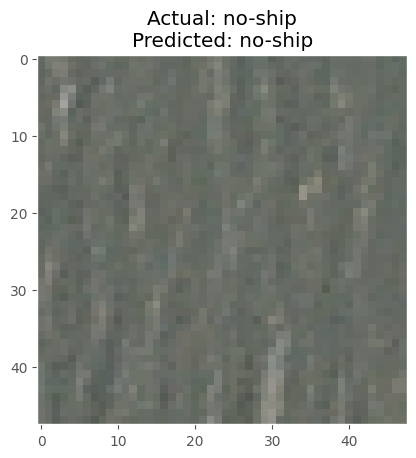

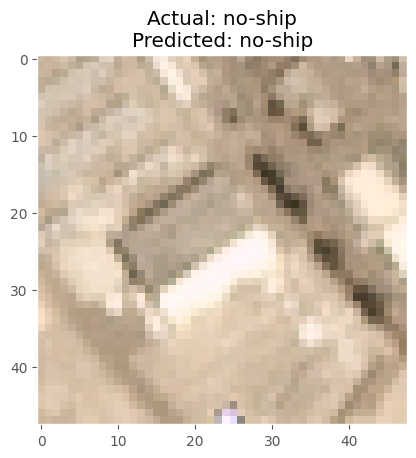

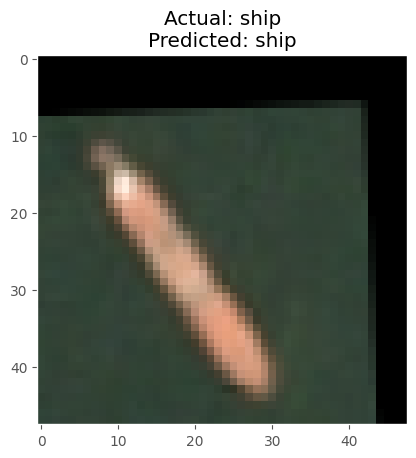

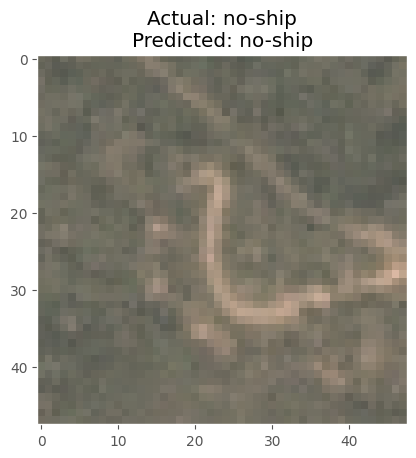

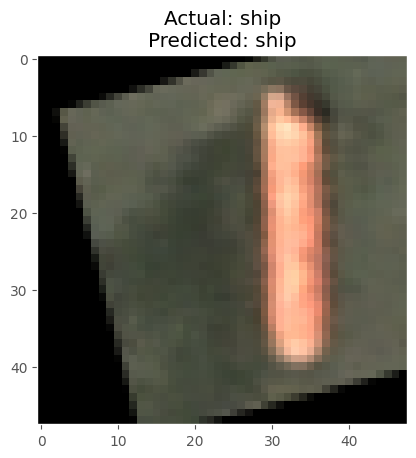

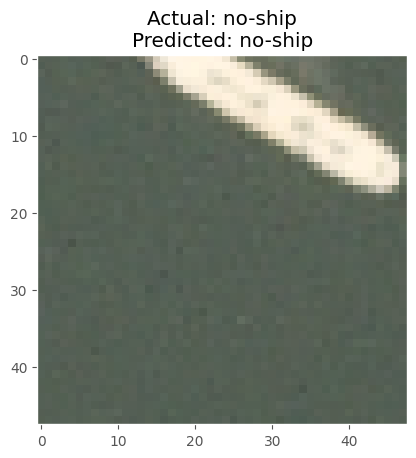

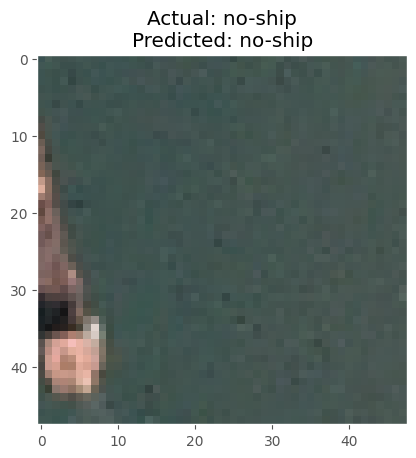

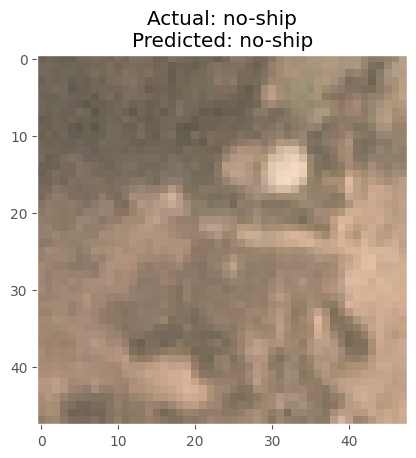

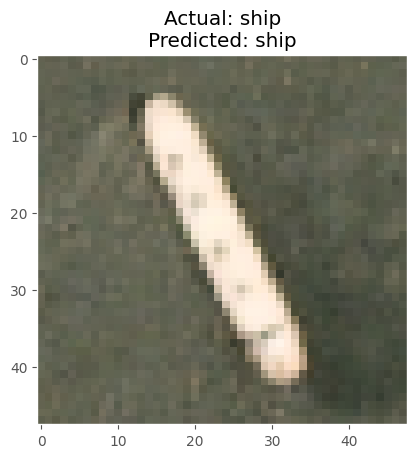

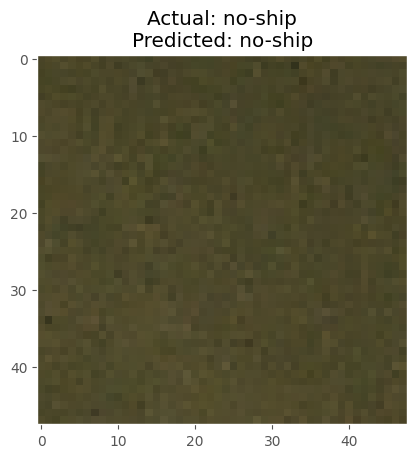

In [ ]:
rnd_idx = random.sample(range(len(test_images)), 10)
# สร้างลิสต์ของดัชนีที่ถูกสุ่มจากชุดข้อมูลการทดสอบ test_images จำนวน 10 ตัว โดยใช้ฟังก์ชัน random.sample() โดยระบุรายการที่สุ่มได้จาก range(len(test_images))

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels # เพื่อทำการวนลูปผ่านคู่ของคลาสและดัชนีของคลาสแต่ละคู่

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx): #วนลูปผ่านดัชนีที่ถูกสุ่มไว้ โดยใช้ enumerate() เพื่อเก็บค่าดัชนีและค่าสุ่มที่ได้

    plt.imshow(test_images[idx]) #  แสดงรูปภาพที่อยู่ในดัชนีที่ถูกสุ่มโดยใช้ plt.imshow()
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]])) # กำหนดหัวข้อของรูปภาพด้วยข้อความที่ระบุคลาสจริงและคลาสที่ทำนายได้
    plt.grid(None) # ไม่แสดงเส้นกริดบนรูปภาพ
    plt.show() # แสดงรูปภาพที่มีคำอธิบายบนหัวข้อ
    pass

In [ ]:
model.save("ship-model.h5")
# ใช้เพื่อบันทึกโมเดลที่ฝึกสอนไว้ในไฟล์ชื่อ "ship-model.h5" โดยใช้เมธอด save()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
